## import libraries

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import PIL
import pywt
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
    device = 'cuda'
    if torch.cuda.device_count()==0:
        dtype = torch.FloatTensor
        device = 'cpu'
else:
    dtype = torch.FloatTensor
    device = 'cpu'
    
from scipy.fftpack import dct
from scipy.fftpack import idct
from scipy import io as sio 
import time
import scipy.io as sio
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
#from torchvision.datasets import CELEBA

num GPUs 1


# load previous experiment

In [2]:
loadfile = True
if loadfile:
    plotvals_loaded = np.load('plotvals_500.npy')
    [y1,y2,y3,y4,cy1,cy2,cy3,cy4] = plotvals_loaded

## load generator pre-trained mnist network

In [3]:
from dcgan import Generator
G1 = Generator(ngpu=1).eval()
# load weights
G1.load_state_dict(torch.load('netG_epoch_99.pth'))
if torch.cuda.is_available():
    G1 = G1.cuda()

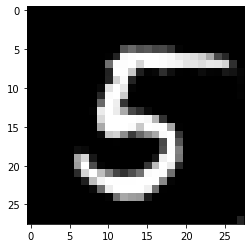

In [4]:
batch_size = 1
latent_size = 100
z_true = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=False)
x_true = G1(z_true).cpu().detach().numpy().squeeze()
plt.imshow(x_true,cmap="gray")

In [5]:
mc = 500
#generate samples z
batch_size = mc
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)

In [6]:
def dfdz(G,z):
    f = G(z).view(-1)
    k = z.view(-1).size()[0]
    d = f.size()[0]
    gradlist = torch.zeros([d,k],dtype=torch.float)
    for i in range(d):
        ff = f[i]
        ff.backward(retain_graph=True)
        gradlist[i,:] = z.grad.squeeze()
        z.grad = torch.zeros_like(z.grad)
    return gradlist # 784 \times 100    

In [7]:
def dfdz2(G,z): #alternate way to compute gradients - appears to give similar values
    k = z.view(-1).size()[0]
    f = G(z).view(-1)
    
    d = f.size()[0]
    gradlist = torch.zeros([d,k],dtype=torch.float)
    for i in range(d):
        f = G(z).view(-1)
        ff = f[i]
        ff.backward()#(retain_graph=True)
        gradlist[i,:] = z.grad.squeeze()
        z.grad = torch.zeros_like(z.grad)
    return gradlist # 784 \times 100    

In [8]:
if not loadfile:
    y1 = []
    y2 = []
    latent_size = 100
    for j in range(mc):
        z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
        dfmat = dfdz(G1,z_j).to('cuda')
        inp1 = torch.matmul(dfmat.T,(G1(z_j).view(-1)-G1(z_true).view(-1)))
        inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
        y1.append(inp2.detach().cpu().numpy())
        normzdiff = torch.norm(z_j-z_true)**2
        y2.append(normzdiff.detach().cpu().numpy())

In [9]:
yy = []
xx = []
beta = 800
alpha = 2
for i in range(mc):
    yy.append(y1[i])
    xx.append(alpha*y2[i]- beta) 

Text(0.5, 1.0, 'DCGAN(MNIST)')

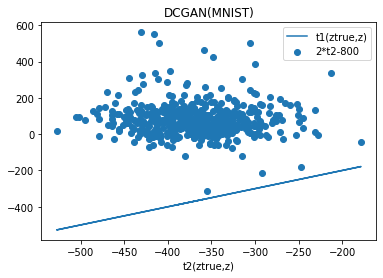

In [10]:
plt.scatter(xx,yy)
plt.plot(xx,xx)
plt.legend(['t1(ztrue,z)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t2(ztrue,z)')
plt.title('DCGAN(MNIST)')

In [11]:
if not loadfile:
    y3 = []
    y4 = []
    latent_size = 100
    for j in range(mc):
        z_t = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=False)
        z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
        dfmat = dfdz(G1,z_j).to('cuda')
        inp1 = torch.matmul(dfmat.T,(G1(z_j).view(-1)-G1(z_t).view(-1)))
        inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_t.squeeze())
        y3.append(inp2.detach().cpu().numpy())
        normzdiff = torch.norm(z_j-z_t)**2
        y4.append(normzdiff.detach().cpu().numpy())

In [12]:
yy = []
xx = []
beta = 800
alpha = 2
for i in range(mc):
    yy.append(y3[i])
    xx.append(alpha*y4[i]- beta) 

Text(0.5, 1.0, 'DCGAN(MNIST)')

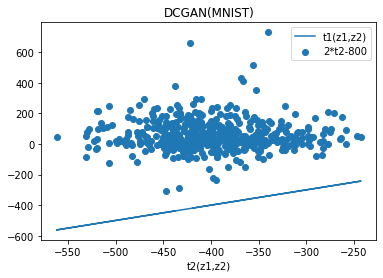

In [13]:
plt.scatter(xx,yy)
plt.plot(xx,xx)
plt.legend(['t1(z1,z2)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t2(z1,z2)')
plt.title('DCGAN(MNIST)')

In [14]:
# check the inequality for random matrix A appended to G, over T trials

In [15]:
d = G1(z_true).nelement()
n = int(0.1*d)
print('dimension of each image:%d, number of samples per image:%d'%(d,n))

dimension of each image:784, number of samples per image:78


In [16]:
T = 5
print('number of instances of sampling matrix A:%d'%(T))

number of instances of sampling matrix A:5


In [17]:
#def forwardA
def forwardA(x,A):
    return torch.matmul(x.view(-1).type(dtype=torch.double),A.T)

In [18]:
mc = 50
#generate samples z
batch_size = mc
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)

In [19]:
loadfileA = False

In [20]:
if not loadfileA:
    y5 = []
    y6 = []
    for k in range(T):
        print('T:%d/%d'%(k+1,T))
        A = torch.tensor(np.random.randn(n,d)/np.sqrt(n)).to('cuda')

        for j in range(mc):
            print('mc:%d/%d'%(j+1,mc))
            z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
            dfmat = dfdz(G1,z_j).to('cuda')
            Adfmat = torch.matmul(A,dfmat.type(dtype=torch.double))
            AGdiff = forwardA((G1(z_j).view(-1)-G1(z_true).view(-1)),A)
            inp1 = torch.matmul(Adfmat.T,AGdiff).type(dtype=torch.float)
            inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
            y5.append(inp2.detach().cpu().numpy())
            normzdiff = torch.norm(z_j-z_true)**2
            y6.append(normzdiff.detach().cpu().numpy())

T:1/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/50
mc:14/50
mc:15/50
mc:16/50
mc:17/50
mc:18/50
mc:19/50
mc:20/50
mc:21/50
mc:22/50
mc:23/50
mc:24/50
mc:25/50
mc:26/50
mc:27/50
mc:28/50
mc:29/50
mc:30/50
mc:31/50
mc:32/50
mc:33/50
mc:34/50
mc:35/50
mc:36/50
mc:37/50
mc:38/50
mc:39/50
mc:40/50
mc:41/50
mc:42/50
mc:43/50
mc:44/50
mc:45/50
mc:46/50
mc:47/50
mc:48/50
mc:49/50
mc:50/50
T:2/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/50
mc:14/50
mc:15/50
mc:16/50
mc:17/50
mc:18/50
mc:19/50
mc:20/50
mc:21/50
mc:22/50
mc:23/50
mc:24/50
mc:25/50
mc:26/50
mc:27/50
mc:28/50
mc:29/50
mc:30/50
mc:31/50
mc:32/50
mc:33/50
mc:34/50
mc:35/50
mc:36/50
mc:37/50
mc:38/50
mc:39/50
mc:40/50
mc:41/50
mc:42/50
mc:43/50
mc:44/50
mc:45/50
mc:46/50
mc:47/50
mc:48/50
mc:49/50
mc:50/50
T:3/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
m

In [21]:
yy = []
xx = []
alpha = 1.5
beta = 1000
for i in range(mc*T):
    yy.append(y5[i])
    xx.append(alpha*y6[i]- beta) 

Text(0.5, 1.0, 'DCGAN(MNIST)')

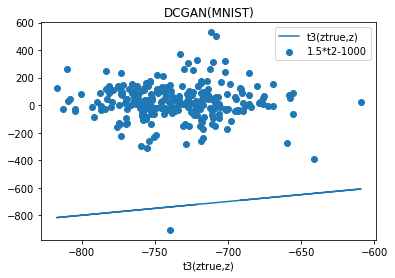

In [22]:
plt.scatter(xx,yy)
plt.plot(xx,xx)
plt.legend(['t3(ztrue,z)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t3(ztrue,z)')
plt.title('DCGAN(MNIST)')

In [23]:
if not loadfileA:
    y7 = []
    y8 = []
    for k in range(T):
        print('%d/%d'%(k+1,T))
        A = torch.tensor(np.random.randn(n,d)/np.sqrt(n)).to('cuda')

        for j in range(mc):
            print('mc:%d/%d'%(j+1,mc))
            z_t = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=False)
            z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
            dfmat = dfdz(G1,z_j).to('cuda')
            Adfmat = torch.matmul(A,dfmat.type(dtype=torch.double))
            AGdiff = forwardA((G1(z_j).view(-1)-G1(z_t).view(-1)),A)
            
            inp1 = torch.matmul(Adfmat.T,AGdiff).type(dtype=torch.float)
            inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_t.squeeze())
            y7.append(inp2.detach().cpu().numpy())
            normzdiff = torch.norm(z_j-z_t)**2
            y8.append(normzdiff.detach().cpu().numpy())

1/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/50
mc:14/50
mc:15/50
mc:16/50
mc:17/50
mc:18/50
mc:19/50
mc:20/50
mc:21/50
mc:22/50
mc:23/50
mc:24/50
mc:25/50
mc:26/50
mc:27/50
mc:28/50
mc:29/50
mc:30/50
mc:31/50
mc:32/50
mc:33/50
mc:34/50
mc:35/50
mc:36/50
mc:37/50
mc:38/50
mc:39/50
mc:40/50
mc:41/50
mc:42/50
mc:43/50
mc:44/50
mc:45/50
mc:46/50
mc:47/50
mc:48/50
mc:49/50
mc:50/50
2/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/50
mc:14/50
mc:15/50
mc:16/50
mc:17/50
mc:18/50
mc:19/50
mc:20/50
mc:21/50
mc:22/50
mc:23/50
mc:24/50
mc:25/50
mc:26/50
mc:27/50
mc:28/50
mc:29/50
mc:30/50
mc:31/50
mc:32/50
mc:33/50
mc:34/50
mc:35/50
mc:36/50
mc:37/50
mc:38/50
mc:39/50
mc:40/50
mc:41/50
mc:42/50
mc:43/50
mc:44/50
mc:45/50
mc:46/50
mc:47/50
mc:48/50
mc:49/50
mc:50/50
3/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/5

In [24]:
yy = []
xx = []
alpha = 2
beta = 750
for i in range(mc):
    yy.append(y7[i])
    xx.append(alpha*y8[i]- beta) 

Text(0.5, 1.0, 'DCGAN(MNIST)')

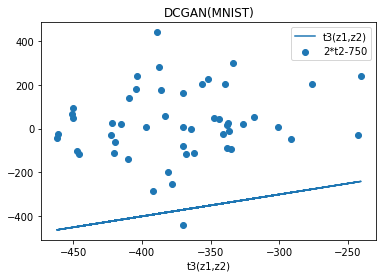

In [25]:
plt.scatter(xx,yy)
plt.plot(xx,xx)
plt.legend(['t3(z1,z2)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t3(z1,z2)')
plt.title('DCGAN(MNIST)')

In [26]:
if not loadfileA:
    plotvals = [y5,y6,y7,y8]
    np.save('plotvalsA_mnist_250.npy',plotvals)

# load generator pre-trained network for cifar

In [27]:
from dcgan_cifar import Generator
G2 = Generator(ngpu=1).eval()
# load weights
G2.load_state_dict(torch.load('netG_epoch_199_cifar.pth'))
if torch.cuda.is_available():
    G2 = G2.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


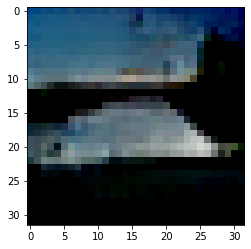

In [28]:
batch_size = 1
latent_size = 100
z_true = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=False)
x_true = G2(z_true).cpu().detach().numpy().squeeze()
plt.imshow(x_true.transpose(1, 2, 0))

In [29]:
mc = 500
#generate samples z
batch_size = mc
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)

In [ ]:
if not loadfile:
    cy1 = []
    cy2 = []
    latent_size = 100
    for j in range(mc):
        z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
        dfmat = dfdz(G2,z_j).to('cuda')
        inp1 = torch.matmul(dfmat.T,(G2(z_j).view(-1)-G2(z_true).view(-1)))
        inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
        cy1.append(inp2.detach().cpu().numpy())
        normzdiff = torch.norm(z_j-z_true)**2
        cy2.append(normzdiff.detach().cpu().numpy())

In [ ]:
cyy = []
cxx = []
beta = 600
alpha = 2
for i in range(mc):
    cyy.append(cy1[i])
    cxx.append(alpha*cy2[i]- beta) 

In [ ]:
plt.scatter(cxx,cyy)
plt.plot(cxx,cxx)
plt.legend(['t1(ztrue,z)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t2(ztrue,z)')
plt.title('DCGAN(CIFAR)')

In [ ]:
if not loadfile:
    cy3 = []
    cy4 = []
    latent_size = 100
    for j in range(mc):
        z_t = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=False)
        z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
        dfmat = dfdz(G2,z_j).to('cuda')
        inp1 = torch.matmul(dfmat.T,(G2(z_j).view(-1)-G2(z_t).view(-1)))
        inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_t.squeeze())
        cy3.append(inp2.detach().cpu().numpy())
        normzdiff = torch.norm(z_j-z_t)**2
        cy4.append(normzdiff.detach().cpu().numpy())

In [ ]:
cyy = []
cxx = []
beta = 800
alpha = 3
for i in range(mc):
    cyy.append(cy3[i])
    cxx.append(alpha*cy4[i]- beta) 

In [ ]:
plt.scatter(cxx,cyy)
plt.plot(cxx,cxx)
plt.legend(['t1(z1,z2)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t2(z1,z2)')
plt.title('DCGAN(CIFAR)')

In [ ]:
if not loadfile:
    plotvals = [y1,y2,y3,y4,cy1,cy2,cy3,cy4]
    np.save('plotvals_500.npy',plotvals)

# check the inequality for random matrix A appended to G, over T trials

In [30]:
d = G2(z_true).nelement()
n = int(0.1*d)
print('dimension of each image:%d, number of samples per image:%d'%(d,n))

dimension of each image:3072, number of samples per image:307


In [31]:
T = 5
print('number of instances of sampling matrix A:%d'%(T))

number of instances of sampling matrix A:5


In [32]:
#def forwardA
def forwardA(x,A):
    return torch.matmul(x.view(-1).type(dtype=torch.double),A.T)

In [33]:
mc = 50
#generate samples z
batch_size = mc
latent_size = 100
z = Variable(torch.randn(batch_size,latent_size,1,1).cuda(), requires_grad=True)

In [34]:
loadfileA = False

In [35]:
if not loadfileA:
    cy5 = []
    cy6 = []
    for k in range(T):
        print('%d/%d'%(k+1,T))
        A = torch.tensor(np.random.randn(n,d)/np.sqrt(n)).to('cuda')

        for j in range(mc):
            z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
            dfmat = dfdz(G2,z_j).to('cuda')
            Adfmat = torch.matmul(A,dfmat.type(dtype=torch.double))
            AGdiff = forwardA((G2(z_j).view(-1)-G2(z_true).view(-1)),A)
            inp1 = torch.matmul(Adfmat.T,AGdiff).type(dtype=torch.float)
            inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_true.squeeze())
            cy5.append(inp2.detach().cpu().numpy())
            normzdiff = torch.norm(z_j-z_true)**2
            cy6.append(normzdiff.detach().cpu().numpy())

1/5
2/5
3/5
4/5
5/5


In [36]:
cyy = []
cxx = []
beta = 450
alpha = 2
for i in range(mc*T):
    cyy.append(cy5[i])
    cxx.append(alpha*cy6[i]- beta) 

Text(0.5, 1.0, 'DCGAN(CIFAR)')

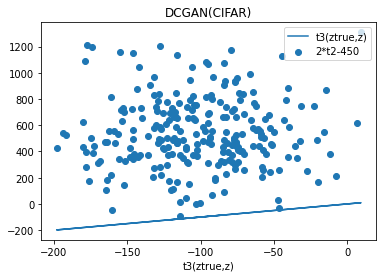

In [37]:
plt.scatter(cxx,cyy)
plt.plot(cxx,cxx)
plt.legend(['t3(ztrue,z)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t3(ztrue,z)')
plt.title('DCGAN(CIFAR)')

In [38]:
if not loadfileA:
    cy7 = []
    cy8 = []
    for k in range(T):
        print('%d/%d'%(k+1,T))
        A = torch.tensor(np.random.randn(n,d)/np.sqrt(n)).to('cuda')

        for j in range(mc):
            print('mc:%d/%d'%(j+1,mc))            
            z_t = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=False)
            z_j = Variable(torch.randn(1,latent_size,1,1).cuda(), requires_grad=True)
            dfmat = dfdz(G2,z_j).to('cuda')
            Adfmat = torch.matmul(A,dfmat.type(dtype=torch.double))
            AGdiff = forwardA((G2(z_j).view(-1)-G2(z_t).view(-1)),A)
            
            inp1 = torch.matmul(Adfmat.T,AGdiff).type(dtype=torch.float)
            inp2 = torch.matmul(inp1.T,z_j.squeeze()-z_t.squeeze())
            cy7.append(inp2.detach().cpu().numpy())
            normzdiff = torch.norm(z_j-z_t)**2
            cy8.append(normzdiff.detach().cpu().numpy())

1/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/50
mc:14/50
mc:15/50
mc:16/50
mc:17/50
mc:18/50
mc:19/50
mc:20/50
mc:21/50
mc:22/50
mc:23/50
mc:24/50
mc:25/50
mc:26/50
mc:27/50
mc:28/50
mc:29/50
mc:30/50
mc:31/50
mc:32/50
mc:33/50
mc:34/50
mc:35/50
mc:36/50
mc:37/50
mc:38/50
mc:39/50
mc:40/50
mc:41/50
mc:42/50
mc:43/50
mc:44/50
mc:45/50
mc:46/50
mc:47/50
mc:48/50
mc:49/50
mc:50/50
2/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/50
mc:14/50
mc:15/50
mc:16/50
mc:17/50
mc:18/50
mc:19/50
mc:20/50
mc:21/50
mc:22/50
mc:23/50
mc:24/50
mc:25/50
mc:26/50
mc:27/50
mc:28/50
mc:29/50
mc:30/50
mc:31/50
mc:32/50
mc:33/50
mc:34/50
mc:35/50
mc:36/50
mc:37/50
mc:38/50
mc:39/50
mc:40/50
mc:41/50
mc:42/50
mc:43/50
mc:44/50
mc:45/50
mc:46/50
mc:47/50
mc:48/50
mc:49/50
mc:50/50
3/5
mc:1/50
mc:2/50
mc:3/50
mc:4/50
mc:5/50
mc:6/50
mc:7/50
mc:8/50
mc:9/50
mc:10/50
mc:11/50
mc:12/50
mc:13/5

In [43]:
cyy = []
cxx = []
beta = 500
alpha = 2.5
for i in range(mc):
    cyy.append(cy7[i])
    cxx.append(alpha*cy8[i]- beta) 

Text(0.5, 1.0, 'DCGAN(CIFAR)')

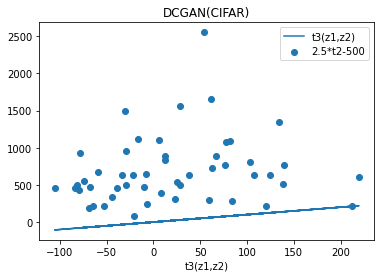

In [44]:
plt.scatter(cxx,cyy)
plt.plot(cxx,cxx)
plt.legend(['t3(z1,z2)',str(alpha)+'*t2-'+str(beta)])
plt.xlabel('t3(z1,z2)')
plt.title('DCGAN(CIFAR)')

In [41]:
if not loadfileA:
    plotvals = [cy5,cy6,cy7,cy8]
    np.save('plotvalsA_cifar_250.npy',plotvals)

In [42]:
if not loadfileA:
    plotvals = [y5,y6,y7,y8,cy5,cy6,cy7,cy8]
    np.save('plotvalsA_250.npy',plotvals)